## Importing libraries

In [1316]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [1317]:
id_num = ['85065', '85012', '85064', '85030',
      '85054', '95040']
id_n = '85054'

In [1318]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id="+id_n;
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Loading some additional data for modeling (weather)

In [1319]:
pd.set_option('display.max_rows', 5000)
df.iloc[[0, -1]]

,Value,Date
0,278.562,2001-01-01
5342,276.360,2015-12-31


In [1320]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2009&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


## Data Fusion

In [1321]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [1322]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [1323]:
ds = ds.loc['2010-01-01':'2015-01-01']

# .........

In [1324]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [1325]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [1326]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [1327]:
#dnew

In [1328]:
#dnew.corr()

In [1329]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(1,26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [1330]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [1331]:
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

Percipitation = dsort['DValue'].index[1]
Sun = dsort['DValue'].index[-1]
for i in dsort['DValue'].index:
    if 'CloudCover' in i:
        Cloud = i
        break
dsort['DValue']   

DValue                           1.000000
Percipitation_average_6d         0.765166
Percipitation_average_7d         0.758988
Percipitation_average_5d         0.757264
Percipitation_average_8d         0.747949
Percipitation_average_9d         0.736422
Percipitation_average_4d         0.726997
Percipitation_average_10d        0.724142
Percipitation_average_11d        0.714754
Percipitation_average_12d        0.704956
Percipitation_average_13d        0.692840
Percipitation_average_14d        0.681014
Percipitation_average_15d        0.667490
Percipitation_average_3d         0.657689
Percipitation_average_16d        0.651431
Percipitation_average_17d        0.635769
Percipitation_average_18d        0.623457
Percipitation_average_19d        0.613264
Percipitation_average_20d        0.602480
Percipitation_average_21d        0.592087
Percipitation_average_22d        0.580626
Percipitation_average_23d        0.567346
Percipitation_average_24d        0.553690
Percipitation_average_25d        0

In [1332]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()
corelated = [Percipitation,
             Cloud,
             Sun,
             #'Percipitation_average_6d',
             #'Percipitation_average_10d',
             #'Percipitation_average_25d',
             #'CloudCover_average_9d',
             #'Sun_duration_average_9d'
            ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [1333]:
data_corelated

,DValue,Percipitation_average_6d,CloudCover_average_7d,Sun_duration_average_5d
Date,,,,
2010-01-01,NaN,NaN,NaN,NaN
2010-01-02,0.04,NaN,NaN,NaN
2010-01-03,0.03,NaN,NaN,NaN
2010-01-04,0.04,NaN,NaN,NaN
2010-01-05,0.03,NaN,NaN,1.760000e+00
2010-01-06,0.02,7.083333e+00,NaN,1.760000e+00
2010-01-07,0.00,5.516667e+00,83.000000,1.760000e+00
2010-01-08,0.00,5.033333e+00,83.428571,1.600000e-01
2010-01-09,0.00,1.015000e+01,83.428571,1.332268e-16


In [1334]:
n=data_corelated['DValue'].isnull().sum()
#data_corelated = data_corelated.fillna(0); #missing data replace vith 0
n

1

# Learn

In [1335]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [1336]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[30:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[30:]

In [1337]:
(y.shape,X.shape)

((1797,), (1797, 3))

In [1338]:
(np.isnan(y).any(),np.isnan(X).any())

(False, False)

In [1339]:
#choose regressor

regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = RandomForestRegressor();
#regressor = SVR();
#regressor = GradientBoostingRegressor();

In [1340]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


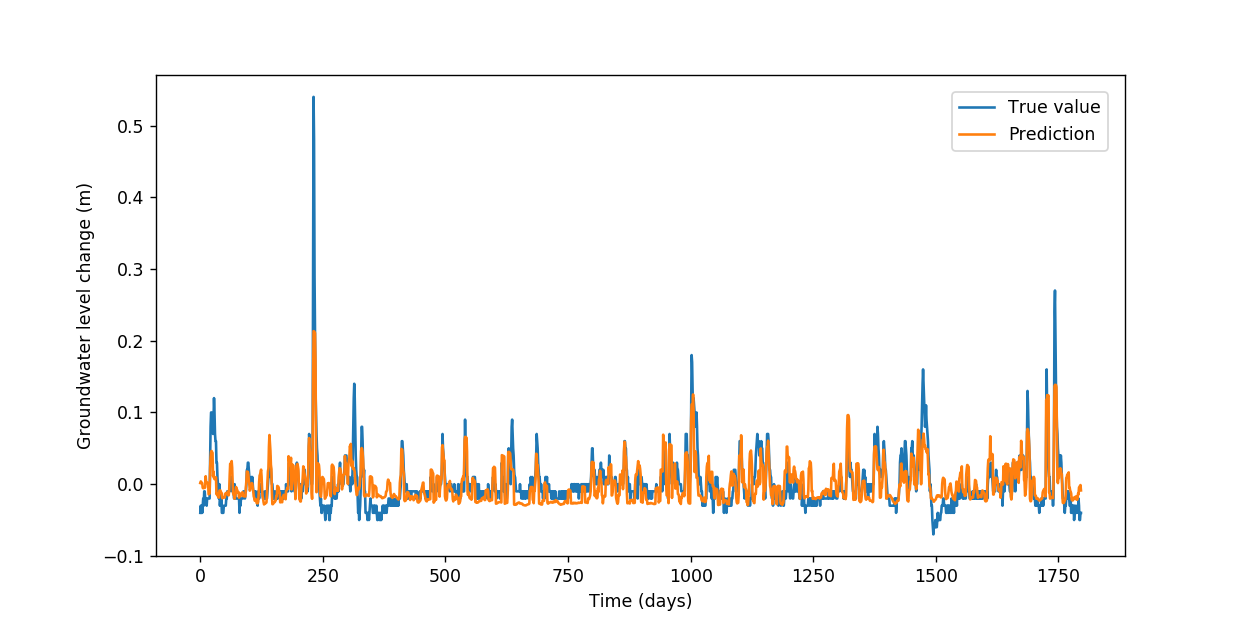

In [1341]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(y)), y, label="True value")
ax.plot(range(len(y)), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [1342]:
#fig.savefig('./graphs/prediction_'+'id='+ id_n +'.png', dpi=300)

In [1343]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.0006330642923733164, 0.5495514213487451)

In [1344]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            GradientBoostingRegressor(),
            SVR(),
            MLPRegressor()
            )
score=[]
for regressor in regressor_list:
    predicted = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted);
    print(mse, r2)
    score.append([mse,r2])

0.0006330642923733164 0.5495514213487451
0.0010615331107401624 0.2446800638027804
0.0008250756855561685 0.41292823759624975
0.0006887558351354551 0.5099248358939652
0.0057248844058960845 -3.073466272929406
0.004883490335341407 -2.4747833781066957


In [1345]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[30:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


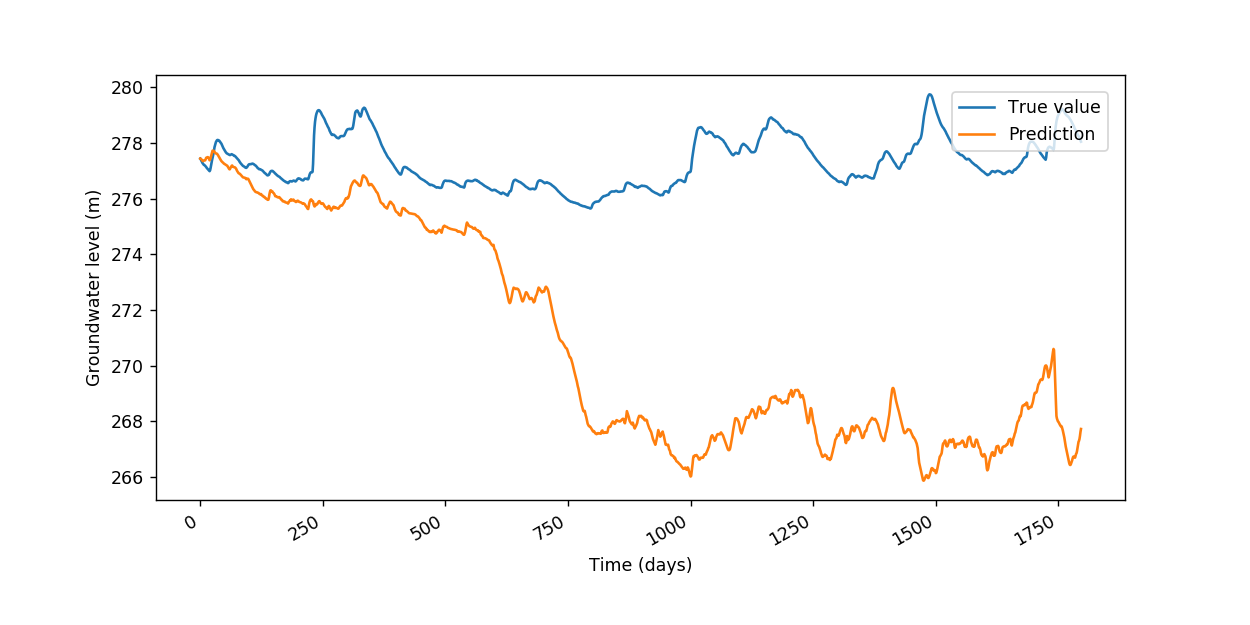

In [1346]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [1347]:
#fig.savefig('./graphs/prediction_cum_'+'id='+ id_n +'.png', dpi=300)

In [1348]:
str(score[0][1])

'0.5495514213487451'

In [1349]:
regressor = ('LinearRegression(): ',
            'DecisionTreeRegressor(): ',
            'RandomForestRegressor(): ',
            'GradientBoostingRegressor(): ',
            'SVR(): ',
            'MLPRegressor(): '
            )
j=0

file = open('./graphs/id='+ id_n +'.txt','w')

file.write('id = '+ id_n)
file.write('\n')
file.write('Training data: ' 
           + Percipitation + ', ' + Cloud + ', ' + Sun +'\n')
file.write('Regressor, mse, R2 \n')
for i in regressor:
    file.write(i + str(score[j][0])+ '  ' + str(score[j][1]) + '\n')
    j += 1



file.close() 